# SHAP all models in a folder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import glob

import numpy as np
import pandas as pd

from src.dataset.data import Dataset
from src.features.build_features import *
from src.features.process_fold import *
from src.features.utils import convert_category_cols_lgb
from src.model.train import *
from src.model.split import CustomDateSplitter
from src.model.utils import load_model
from src.visualization.model_visualizer import *

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = None
pd.options.display.max_columns = None

%matplotlib inline

In [4]:
ds = Dataset()
ds.load_dataset("lgb_processed")

In [5]:
date_ranges = [
        # [["2018-01-01", "2018-05-31"], ["2017-12-01", "2017-12-31"]],
        [["2017-12-01", "2018-04-15"], ["2018-05-01", "2018-05-31"]]
    ]
folds = CustomDateSplitter(ds.X_train["TransactionDT"], date_ranges)

In [6]:
convert_category_cols_lgb(ds)

In [7]:
(train_index, valid_index) = list(folds.split(ds.X_train))[0]
X_train, X_valid = (ds.X_train.iloc[train_index], ds.X_train.iloc[valid_index])
y_train, y_valid = ds.y_train.iloc[train_index], ds.y_train.iloc[valid_index]
fold = Fold(X_train, y_train, X_valid, y_valid, ds.X_test)
process_fold(fold)

## Analyze all models in a folder

In [8]:
folder = "lgb_09162019_0847"
all_models = [load_model(f"{folder}/{os.path.basename(path)[0:6]}") for path in glob.glob(f"../../models/{folder}/*.dat")]

In [22]:
all_tvs = [TreeVisualizer(model, fold.X_train.sample(1000, random_state=i)) for i, model in enumerate(all_models)]

In [23]:
feat_importance = all_tvs[0].get_importances()

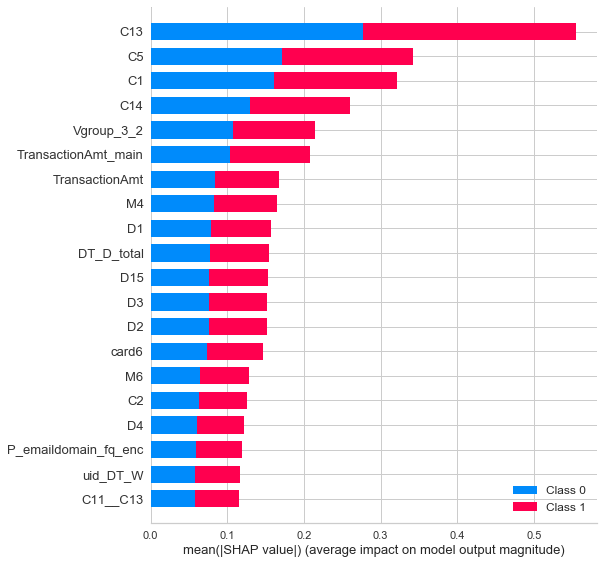

In [26]:
for tv in all_tvs:
    tv.summary_bar_plot()

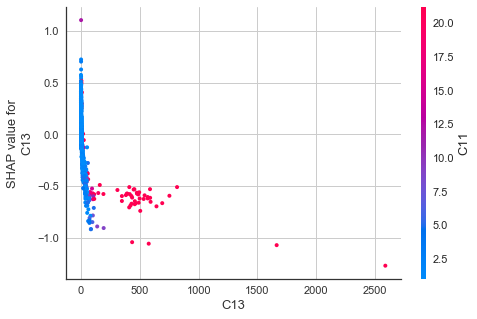

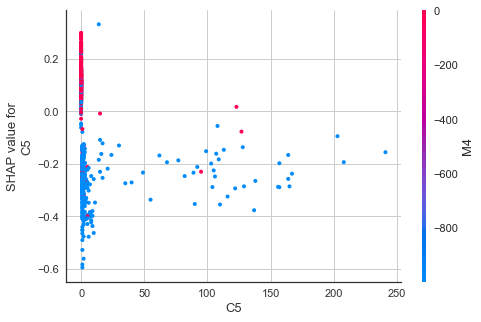

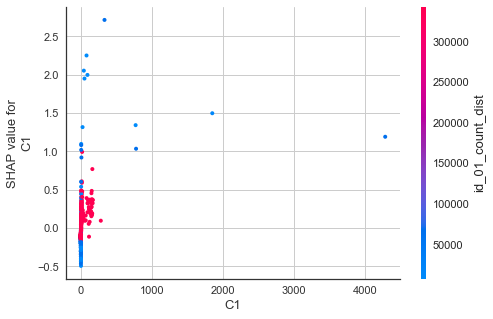

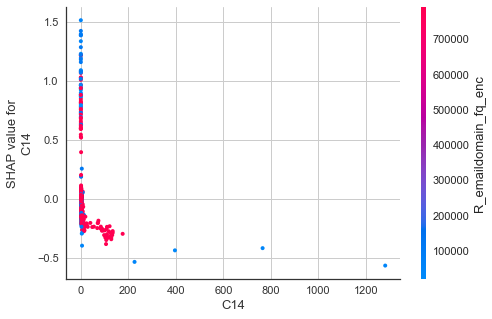

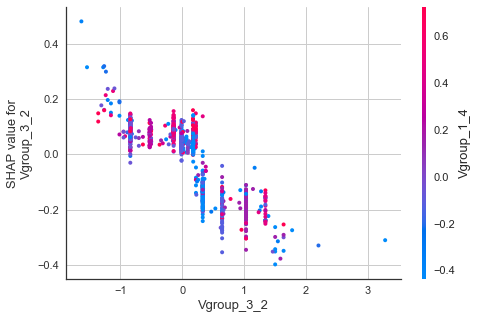

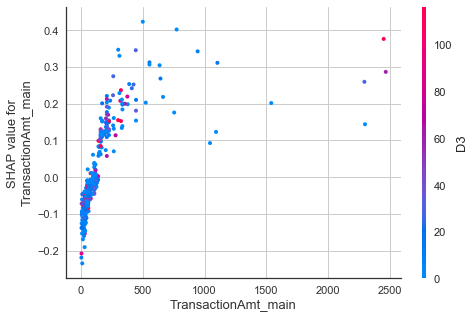

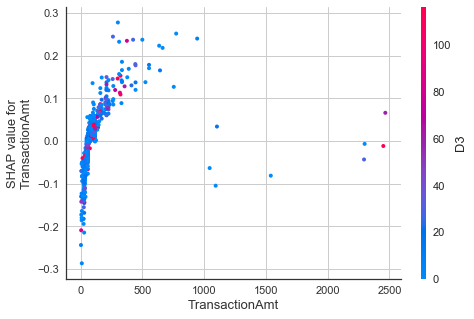

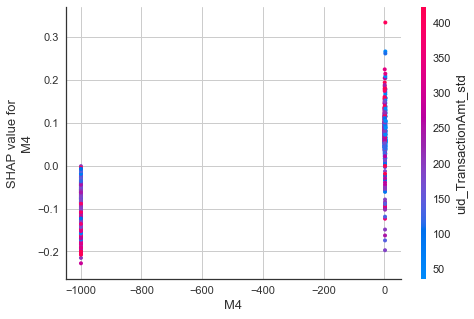

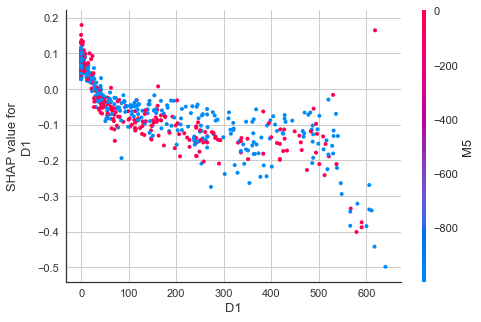

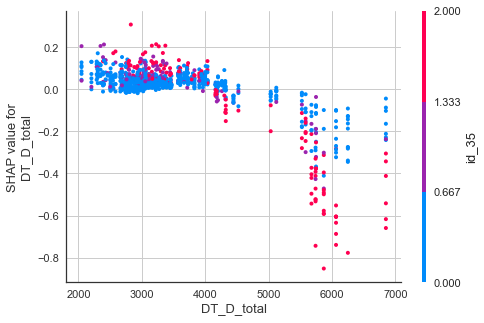

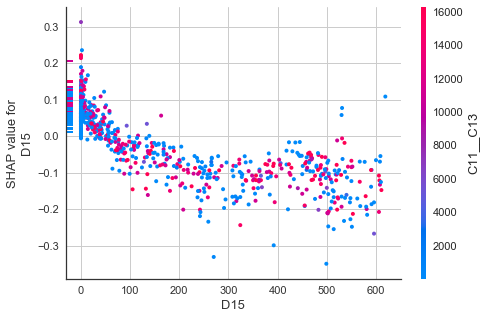

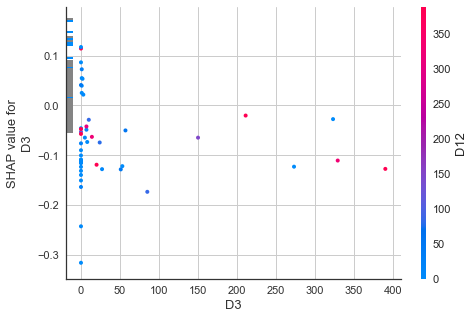

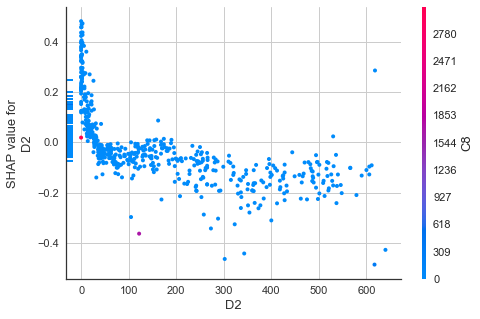

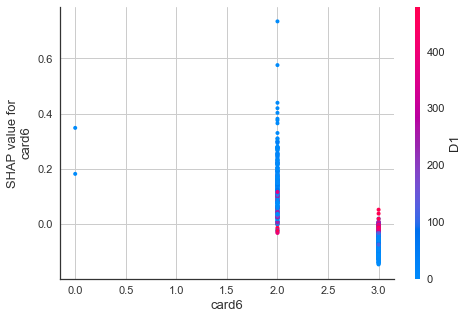

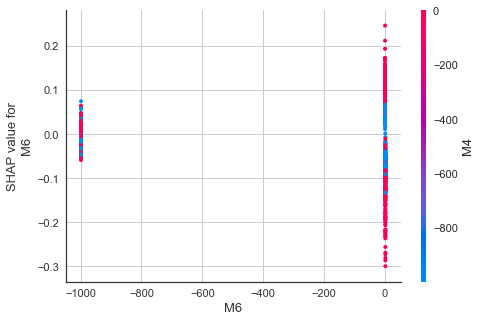

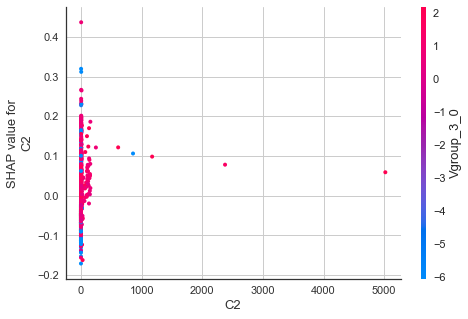

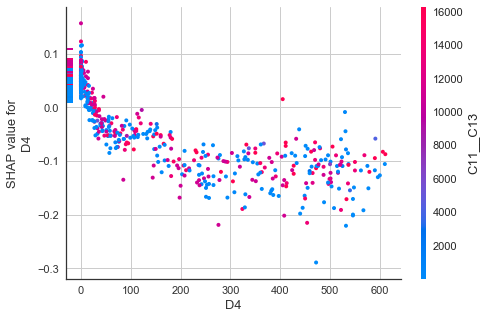

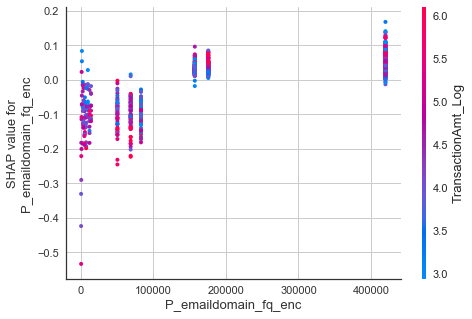

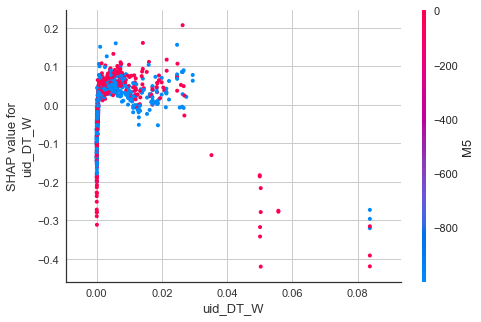

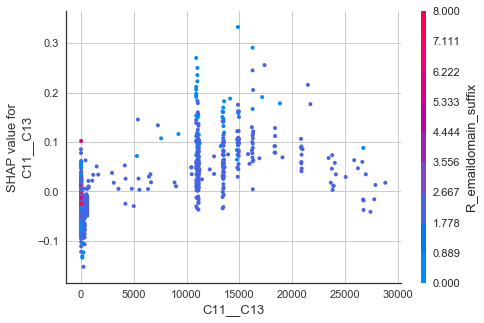

In [33]:
for tv in all_tvs:
    for i in range(20):
        tv.dependence_plot(f'rank({i})')

## Permutation importance

About an hour of processing for 200 columns

In [9]:
perm_importance = permutation_importance_lgb(fold.X_valid, fold.y_valid, all_models[0])

In [18]:
permutation_df = pd.DataFrame.from_dict({'column': list(perm_importance.keys()), 'error': list(perm_importance.values())}) 

In [24]:
permutation_df.sort_values('error').head(20)

,column,error
13,C1,-0.022028
24,C13,-0.009477
25,C14,-0.005436
27,D2,-0.003869
14,C2,-0.003059
17,C6,-0.002580
22,C11,-0.002473
114,uid4_TransactionAmt_std,-0.002267
44,M5,-0.002173
185,P_emaildomain_fq_enc,-0.001834
